# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# magic word for producing visualizations in notebook
%matplotlib inline

''' Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn. '''

' Import note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn. '

In [3]:
def print_df_missing_data(df):
    """ Convenience function to print."""
    row, col = df.shape
    tmp = df.isna().sum()*100/row
    res = tmp[tmp>0].sort_values(ascending=False)
    print(f"Shape [{row}][{col}]\n {len(res)} have missing data \n {res} % where attributes have missing data")
    return res
    
def find_binary_categorical(df, categorical):
    """ Convenience function to create a list with name of the (categorical & binary) attributes
        INPUT:  DF
        OUTPUT: list
    """
    categorical_bin = []
    for col in categorical:
        tmp = df[col].unique()
        #print(f"{col}:\t\t{tmp}")
        if len(tmp) == 2:
            categorical_bin.append(col) 
    print("Binary attributes:", categorical_bin)
    return categorical_bin

def scree_plot(pca):
    ''' Creates a scree plot associated with the principal components 
        INPUT:  pca - the result of instantian of PCA in scikit learn
        OUTPUT: None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [4]:
def clean_data(azdias, feat_info):
    """ Perform feature trimming, re-encoding, and engineering for demographics data
        INPUT: Demographics DataFrame
        OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    print(f"\tShape of DF:{azdias.shape} ")
    max_row, max_col = azdias.shape
    
    print("1. Convert missing value codes into NaNs...")
    df = feat_info
    df['Flags'] = df.iloc[:,3].apply(lambda x: x[1:-1].split(',')) # Convert the str to list of str

    df2 = azdias.copy()
    for index, row in df.iterrows(): 
        attr = row["attribute"]
        flags = row["Flags"]
        for flag in flags: 
            if flag == 'X' or flag == 'XX':                   # case where there is a str
                df2[attr].replace(flag, np.nan, inplace=True)
            elif flag == '':                                  # Case where there is no item
                continue
            else:                                             # Case where there is a integer
                df2[attr].replace(int(flag), np.nan, inplace=True)
                #print(attr, flag, test)
    azdias = df2            
    
    print("2. Removing cols with alot of missing data...")
    post = azdias.isna().sum() 
    criterion = 200000  # Will hard-code the list here so it can work on general population
    col_to_investigate = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'] 
    azdias_new  = azdias.drop(col_to_investigate, axis=1)
    print(f"\tCol drop criterion > {criterion:,}")
    print(f"\tDrop {len(col_to_investigate)} attributes: {col_to_investigate}")
    print(f"\tShape of DF:{azdias_new.shape} ")
    max_col_new = azdias_new.shape[1]

    print("3. Removing rows with alot of missing data...")
    row_missing_data = azdias_new.isna().sum(axis=1)/max_col_new   # represent as %
    criterion = .2
    list_of_rows = row_missing_data[row_missing_data>criterion].index.tolist()  
    print(f"\tRow drop criterion > {criterion*100:.2f}%")
    print(f"\tDrop {len(list_of_rows):,} or {len(list_of_rows)*100/max_row:.2f}% of rows")
    azdias_new_low = azdias_new.drop(list_of_rows)
    print(f"\tShape of DF:{azdias_new_low.shape} ")
    azdias_new2 = azdias_new_low.copy()
    
    ### select, re-encode, and engineer column values.
    
    # Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?
    categorical = feat_info[feat_info['type'] == 'categorical']['attribute'].tolist()  # get a list of categorical attributes 
    mixed       = feat_info[feat_info['type'] == 'mixed']['attribute'].tolist()        # get a list of mixed attributes
    mixed.remove("KBA05_BAUMAX")                                                       # Already removed
    categorical = list(set(categorical) & set(azdias_new_low.columns))   # Necessary to eliminate the attributes already eliminated

    print("4. Convert binary attribute to number...")
    quick_dict = {'W': 1, 'O':2}
    azdias_new2['OST_WEST_KZ'] = azdias_new2['OST_WEST_KZ'].replace(quick_dict)


    print("5. Remove the binary attributes")
    categorical_to_drop = ['LP_STATUS_FEIN', 'LP_STATUS_GROB', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 
                           'NATIONALITAET_KZ', 'CAMEO_DEU_2015', 'SHOPPER_TYP', 'VERS_TYP', 
                           'CAMEO_DEUG_2015', 'FINANZTYP', 'CJT_GESAMTTYP', 'GEBAEUDETYP', 'ZABEOTYP', 'LP_FAMILIE_GROB']

    print(f"\tDrop {len(categorical_to_drop)} categorical attributes" )

    azdias_new2.drop(categorical_to_drop, axis=1, inplace=True)
    print(f"\tShape of DF: {azdias_new2.shape}")
    
    PRAEGENDE_dict = { 1: [40, 1],  2: [40, 2], 3: [50, 1],  4: [50, 2],
                       5: [60, 1],  6: [60, 2], 7: [60, 2],  8: [70, 1], 9: [70, 2],
                      10: [80, 1], 11: [80, 2], 12: [80, 1], 13: [80, 2], 
                      14: [90, 1], 15: [90, 2], np.nan: [90, 1]
                     }

    # Create a DF with the lists in each cell 
    print("6. Cleaning two mixed attributes...")
    b = azdias_new2["PRAEGENDE_JUGENDJAHRE"].map(PRAEGENDE_dict).to_frame()  
    azdias_new2[['decade','movement']]= pd.DataFrame(b.PRAEGENDE_JUGENDJAHRE.tolist(), index= b.index) # Create the two columns
    
    
    azdias_new2["CAMEO_INTL_2015"].replace(np.nan, 52, inplace=True)  
    
    mixed.remove("CAMEO_INTL_2015")  # Do not remove this column
    
    azdias_new2.drop(mixed, axis=1, inplace=True)
    print(f"\tDropping {len(mixed)} mixed attributes: {mixed}")
    print(f"\tShape of DF: {azdias_new2.shape}")

    # Data type of the attribute is string. Need to convert to integer first. 
    # Then note that by dividing by 10 and reconverting to integer we can do the mapping
    azdias_new2["CAMEO_INTL_2015"] = azdias_new2["CAMEO_INTL_2015"].astype('int').div(10).astype('int')
    
    ### Return the cleaned dataframe.
    print("*** DONE! ***")
    return azdias_new2

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [5]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

### Identify missing or unknown data values and convert them to NaNs.
*Notes*. By looking at data dictionary
* -1 always means missing data
* 0  often means no classification but can also be missing data (e.g., 1.7, 3.1) or be ok in the case of 5.1, 5.2, 5.3
* 9  can also be missing data but in some cases it means uniformly distributed data
* XX, X means missing data

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of rows and columns, print the first few rows).
max_row, max_col   = azdias.shape
max_row2, max_col2 = feat_info.shape
print(f"General Germany population - azdias: \t{max_row:,} rows X {max_col} cols")
print(f"Demographic features - feat_info:\t{max_row2:,} rows X {max_col2} cols")
col_obj = azdias.loc[:, azdias.dtypes == object].columns
print(f"{len(col_obj)} cols are objects: {col_obj}")

General Germany population - azdias: 	891,221 rows X 85 cols
Demographic features - feat_info:	85 rows X 4 cols
4 cols are objects: Index(['OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015'], dtype='object')


In [5]:
#print(azdias.info())
#print(feat_info.info())
#azdias.head()
#feat_info.head()

In [6]:
df = feat_info
print(f"\t Converting col 4 to a dict with key:flag and value:list of attributes where flag is found")
df['Flags'] = df.iloc[:,3].apply(lambda x: x[1:-1].split(',')) # Convert the str to list of str

	 Converting col 4 to a dict with key:flag and value:list of attributes where flag is found


In [7]:
df.loc[0:5,:]

attribute information_level         type missing_or_unknown  \
0              AGER_TYP            person  categorical             [-1,0]   
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]   
2             ANREDE_KZ            person  categorical             [-1,0]   
3         CJT_GESAMTTYP            person  categorical                [0]   
4     FINANZ_MINIMALIST            person      ordinal               [-1]   
5         FINANZ_SPARER            person      ordinal               [-1]   

        Flags  
0     [-1, 0]  
1  [-1, 0, 9]  
2     [-1, 0]  
3         [0]  
4        [-1]  
5        [-1]

In [8]:
#df2 = azdias.copy()
#df2.AGER_TYP.count("-1")
#df2.groupby('ALTERSKATEGORIE_GROB').count()
#df['category'].value_counts()
#df2['ALTERSKATEGORIE_GROB'].value_counts()
#df2['ALTERSKATEGORIE_GROB'][df2['ALTERSKATEGORIE_GROB'] == 9].count()

In [9]:
df2 = azdias.copy()
print(df2['ALTERSKATEGORIE_GROB'].value_counts())
print(df2['CAMEO_DEUG_2015'].value_counts())

3    358533
4    228510
2    158410
1    142887
9      2881
Name: ALTERSKATEGORIE_GROB, dtype: int64
8    134441
9    108177
6    105874
4    103912
3     86779
2     83231
7     77933
5     55310
1     36212
X       373
Name: CAMEO_DEUG_2015, dtype: int64


**Replace the flags with np.nan**

In [10]:
df2 = azdias.copy()
test = 0 # makes it easy to exit
for index, row in df.iterrows(): 
    attr = row["attribute"]
    flags = row["Flags"]
    for flag in flags: 
        if flag == 'X' or flag == 'XX':                   # case where there is a str
            df2[attr].replace(flag, np.nan, inplace=True)
        elif flag == '':                                  # Case where there is no item
            continue
        else:                                             # Case where there is a integer
            df2[attr].replace(int(flag), np.nan, inplace=True)
            #print(attr, flag, test)
            test += 1
        
    if test == 95:
        break

In [11]:
print(df2['ALTERSKATEGORIE_GROB'].value_counts()) 
print(df2['CAMEO_DEUG_2015'].value_counts())

3.0    358533
4.0    228510
2.0    158410
1.0    142887
Name: ALTERSKATEGORIE_GROB, dtype: int64
8    134441
9    108177
6    105874
4    103912
3     86779
2     83231
7     77933
5     55310
1     36212
Name: CAMEO_DEUG_2015, dtype: int64


In [12]:
azdias = df2
post = azdias.isna().sum()
print(f" No. of attributes with missing data {post[post>0].count()} out of {max_col}") 
id_max = post.idxmax()
print(f" {id_max} has max missing data of any attribute with {100*post[post>0].max()/max_row:.2f}%")  
#post
#pre-post

 No. of attributes with missing data 61 out of 85
 TITEL_KZ has max missing data of any attribute with 99.76%


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [14]:
# Perform an assessment of how much missing data there is in each column of the dataset.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)
ax1.hist(post, bins=10,  color='#86bf91')
ax1.set_ylabel('Number of attributes')
ax1.set_title('Histogram - bin = 10')

ax2.hist(post, bins=25, color='#86bf91')
ax1.set_xlabel('Number of missing data for attributes')
ax2.set_xlabel('Number of missing data for attributes')
ax2.set_title('Histogram - bin = 25');

The histograms with two different bin size show that there is a real break point close to 200,000 and we could drop all the attributes with more than 200,000 missing data

In [15]:
criterion = 200000
col_to_investigate = post[post>criterion].index.tolist()
print(f"How many attributes to investigate (exceed threshold of {criterion:,}): {len(col_to_investigate )} out of {max_col} attributes")
#col_to_investigate 

How many attributes to investigate (exceed threshold of 200,000): 6 out of 85 attributes


In [16]:
col_to_investigate

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [17]:
# Investigate patterns in the amount of missing data in each column.
#print(f"Data types: {azdias[col_to_investigate].dtypes}")
print(f"Percent missing data in each attributes:")
print_df_missing_data(azdias[col_to_investigate]);

Percent missing data in each attributes:
Shape [891221][6]
 6 have missing data 
 TITEL_KZ        99.757636
AGER_TYP        76.955435
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
GEBURTSJAHR     44.020282
ALTER_HH        34.813699
dtype: float64 % where attributes have missing data


In [18]:
feat_info_index = feat_info.set_index('attribute')   # Create index DF to make easy to isolate the attributes to investigate
feat_info_index.loc[col_to_investigate, :]

information_level         type missing_or_unknown    Flags
attribute                                                              
AGER_TYP                person  categorical             [-1,0]  [-1, 0]
GEBURTSJAHR             person      numeric                [0]      [0]
TITEL_KZ                person  categorical             [-1,0]  [-1, 0]
ALTER_HH             household     interval                [0]      [0]
KK_KUNDENTYP         household  categorical               [-1]     [-1]
KBA05_BAUMAX     microcell_rr3        mixed             [-1,0]  [-1, 0]

In [19]:
# Remove the outlier columns from the dataset. (You'll perform other data engineering tasks such as re-encoding and imputation later.)
print(f"Removing the following {len(col_to_investigate)} attributes: {col_to_investigate}")
azdias_new = azdias.drop(col_to_investigate, axis=1)
max_col_new = azdias_new.shape[1]
print(f"Number of attributes left: {max_col_new}")

Removing the following 6 attributes: ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
Number of attributes left: 79


#### Discussion 1.1.2: Assess Missing Data in Each Column

I followed multiple steps to identify and explore missing data
* I noticed that 19 attributes already had alot of missing data (+15%). KK_KUNDENTYP already had more than 65% of data missing. That will clearly be a candidate for droping
* I parsed the 4th column of feat_info to identify columns where some "flag" data was found. The flag data were strings: "-1", "0", "9", "X", "XX". The number of attributes touched: 62, 29, 18, 1, and 2 respectively
* I check to see if the sample rows had the flags in the identified attributes. To my surprised, that was not always the case and the number of attributes that followed the flags were 4/62, 16/29, 3/18, 1/1, 2/2 following the same ordered list of flags. The "-1" flag in particular seems to not have been used as often than anticipated (only 4 attributes out of the 62).
* I replaced these flags with NaN in the subset of columns that had identified the flag
* Then the histogram analysis showed that the number 6 attributes had more than 35% of missing data. 5 more than originally.
* My quick check on type of data did not revealed any pattern. Had categorical, numeric, interval and mix data types. They covered personal, houselhold and microcell data.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [20]:
# How much data is missing in each row of the dataset?
row_missing_data = azdias_new.isna().sum(axis=1) / max_col_new   # represent as %
azdias_new['percent_missing'] = row_missing_data

In [21]:
criterion = .2
list_of_rows = row_missing_data[row_missing_data>criterion].index.tolist()  
print(f"Rows with more than {criterion*100:.2f}% missing data is {len(list_of_rows):,} or {len(list_of_rows)*100/max_row:.2f}%")

Rows with more than 20.00% missing data is 98,929 or 11.10%


In [22]:
azdias_new_high = azdias_new.loc[list_of_rows]
azdias_new_low  = azdias_new.drop(list_of_rows)
print(f"Low:{azdias_new_low.shape} High:{azdias_new_high.shape}\nPercent rows in high {azdias_new_high.shape[0]*100/max_row:.2f}%")
max_row == azdias_new_low.shape[0] + azdias_new_high.shape[0]

Low:(792292, 80) High:(98929, 80)
Percent rows in high 11.10%


True

In [23]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

Text(0.5,0,'% missing data')

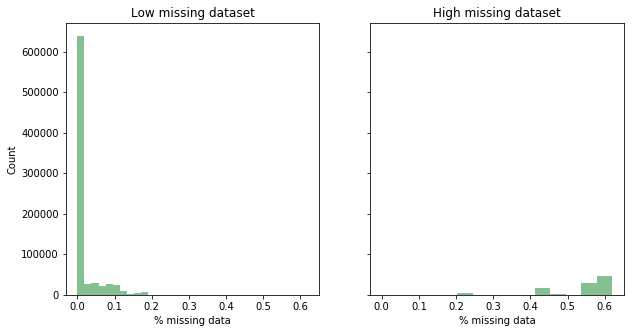

In [24]:
# Compare the two datasets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)
#ax1 = sns.countplot(x='percent_missing', data=azdias_new_high)
#ax2 = sns.countplot(x='percent_missing', data=azdias_new_low)
ax1.hist(azdias_new_low.percent_missing, bins=10,  color='#86bf91')
ax1.set_ylabel('Count')
ax1.set_xlabel('% missing data')
ax1.set_title('Low missing dataset')

ax2.hist(azdias_new_high.percent_missing, bins=10,  color='#86bf91')
ax2.set_title('High missing dataset')
ax2.set_xlabel('% missing data')

In [25]:
# Remove extra column from both DF
azdias_new_high.drop('percent_missing', axis=1, inplace=True)
azdias_new_low.drop('percent_missing',  axis=1, inplace=True)

In [26]:
test = azdias_new_low.isna().sum(axis=1)                      # count the number of missing data by row
print(f"Row with NO missing data: {test[test==0].count()*100/max_row:.2f}%")

Row with NO missing data: 69.94%


In [27]:
test_col = azdias_new_low.isna().sum(axis=0)    # count the number of missing data by col
print(f"Col with NO missing data: {test_col[test_col==0].count()}") 

Col with NO missing data: 33


In [28]:
clean_col = test_col[test_col==0].index.tolist()   # List of col with no missing data
comp_df = pd.DataFrame()
start = 2
comp_df['mean_low']  = azdias_new_low[clean_col[start:-1:6]].mean()
comp_df['mean_high'] = azdias_new_high[clean_col[start:-1:6]].mean()
comp_df['std_low']   = azdias_new_low[clean_col[start:-1:6]].std()
comp_df['std_high']  = azdias_new_high[clean_col[start:-1:6]].std()
print(f"mean {comp_df}")

mean                   mean_low  mean_high   std_low  std_high
FINANZ_SPARER     2.714529   3.674039  1.485390  0.916163
GREEN_AVANTGARDE  0.219976   0.009502  0.414230  0.097013
SEMIO_LUST        4.341223   4.502148  2.102636  1.196683
SEMIO_KAEM        4.295161   5.645079  1.868388  1.155593
ANZ_TITEL         0.004154   0.004404  0.068534  0.078201


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

I chose to separate data into two DF when a row exceed the threshold of 20% missing data in a row. 11% of the rows met that criteria and was part of the high DF. I also noticed that almost 70% of the rows had no missing data which is encouraging.

When I compared the averages and standard deviations between the two DF, I noticed that on all averages from the low DF were also lower than the averages of the high DF from attributes that all their data. That led me to the hypothesis that some of the data that were not considered missing values might be small and therefore explained why the averages were lower. I also noticed that the standard deviation was also mostly bigger for in the low DF, this might also support the hypothesis.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [29]:
# How many features are there of each data type?
feat_info.groupby('type').agg(['count'])

attribute information_level missing_or_unknown Flags
                count             count              count count
type                                                            
categorical        21                21                 21    21
interval            1                 1                  1     1
mixed               7                 7                  7     7
numeric             7                 7                  7     7
ordinal            49                49                 49    49

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [30]:
# Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?
categorical  = feat_info[feat_info['type'] == 'categorical']['attribute'].tolist()  # get a list of categorical attributes 
mixed        = feat_info[feat_info['type'] == 'mixed']['attribute'].tolist()        # get a list of mixed attributes
mixed.remove("KBA05_BAUMAX")                                                        # Already removed
categorical2 = list(set(categorical) & set(azdias_new_low.columns))   # Necessary to eliminate the attributes already eliminated
print(f"Number of categorical attributes: {len(categorical2)}")
azdias_new2 = azdias_new_low.copy()

Number of categorical attributes: 18


In [31]:
print(f"Number of mixed attributes: {len(mixed)}\n{mixed}")

Number of mixed attributes: 6
['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']


In [32]:
categorical_df = azdias_new_low.loc[:, categorical2]      # DF with only categorical attributes
#categorical_df.head()
#categorical_df.dtypes

In [33]:
print(f"If greater than zero, percent missing data in each categorical attributes:")
a = print_df_missing_data(categorical_df);

If greater than zero, percent missing data in each categorical attributes:
Shape [792292][18]
 11 have missing data 
 VERS_TYP            4.525478
SHOPPER_TYP         4.525478
NATIONALITAET_KZ    4.179646
LP_FAMILIE_GROB     3.850979
LP_FAMILIE_FEIN     3.850979
CJT_GESAMTTYP       0.551312
GFK_URLAUBERTYP     0.551312
LP_STATUS_GROB      0.551312
LP_STATUS_FEIN      0.551312
CAMEO_DEUG_2015     0.544875
CAMEO_DEU_2015      0.544875
dtype: float64 % where attributes have missing data


In [34]:
categorical_bin = find_binary_categorical(azdias_new2, categorical2)

Binary attributes: ['GREEN_AVANTGARDE', 'OST_WEST_KZ', 'SOHO_KZ', 'ANREDE_KZ']


In [35]:
# Re-encode categorical variable(s) to be kept in the analysis. Convert the binary variable to numbers
quick_dict = {'W': 1, 'O':2}
azdias_new2['OST_WEST_KZ'] = azdias_new2['OST_WEST_KZ'].replace(quick_dict)

In [36]:
# Remove the binary attributes
categorical_to_drop = categorical2
for col in categorical_bin:
    categorical_to_drop.remove(col)

print(f"Drop {len(categorical_to_drop)} attributes because they are not binary: {categorical_to_drop}" )
azdias_new2.drop(categorical_to_drop, axis=1, inplace=True)
print(f"Size of DF: {azdias_new2.shape}")

Drop 14 attributes because they are not binary: ['LP_STATUS_FEIN', 'LP_STATUS_GROB', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'NATIONALITAET_KZ', 'CAMEO_DEU_2015', 'SHOPPER_TYP', 'VERS_TYP', 'CAMEO_DEUG_2015', 'FINANZTYP', 'CJT_GESAMTTYP', 'GEBAEUDETYP', 'ZABEOTYP', 'LP_FAMILIE_GROB']
Size of DF: (792292, 65)


In [37]:
print_df_missing_data(azdias_new2);

Shape [792292][65]
 35 have missing data 
 KKK                      7.619539
REGIOTYP                 7.619539
W_KEIT_KIND_HH           7.326844
LP_LEBENSPHASE_FEIN      6.159472
LP_LEBENSPHASE_GROB      5.806066
HEALTH_TYP               4.525478
KBA05_ANTG1              4.375533
KBA05_ANTG2              4.375533
KBA05_ANTG3              4.375533
KBA05_ANTG4              4.375533
KBA05_GBZ                4.375533
MOBI_REGIO               4.375533
PRAEGENDE_JUGENDJAHRE    3.485457
PLZ8_HHZ                 2.266589
PLZ8_GBZ                 2.266589
PLZ8_ANTG1               2.266589
PLZ8_ANTG2               2.266589
PLZ8_ANTG3               2.266589
PLZ8_ANTG4               2.266589
PLZ8_BAUMAX              2.266589
KBA13_ANZAHL_PKW         1.057691
ANZ_HAUSHALTE_AKTIV      0.780015
RETOURTYP_BK_S           0.551312
ONLINE_AFFINITAET        0.551312
CAMEO_INTL_2015          0.544875
ORTSGR_KLS9              0.506505
ARBEIT                   0.506505
RELAT_AB                 0.506505
ANZ_H

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

While there were initially 21 categorical attributes, I had already dropped 3 because of high missing data and therefore investigated 18. Three of them were object/strings attributes but one of them was binary. I transformed that binary string attribute to numerical one. A suggested, to keep things straightforward, I only kept the binary attributes which were ['SOHO_KZ', 'OST_WEST_KZ', 'ANREDE_KZ', 'GREEN_AVANTGARDE'].

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [38]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
print(f"Missing data in PRAEGENDE:{100*azdias_new2['PRAEGENDE_JUGENDJAHRE'].isnull().sum()/max_row:.2f}%")
print(f"Unique data in PRAEGENDE: {azdias_new2['PRAEGENDE_JUGENDJAHRE'].unique()}")

Missing data in PRAEGENDE:3.10%
Unique data in PRAEGENDE: [ 14.  15.   8.   3.  10.  11.   5.   9.   6.   4.  nan   2.   1.  12.  13.
   7.]


In [39]:
# look for distribution of value
distr = azdias_new2.groupby(["PRAEGENDE_JUGENDJAHRE"])["PRAEGENDE_JUGENDJAHRE"].agg('count')
#distr

In [40]:
"""
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)"""
# Mainstream => 1, Avantguard => 2, 
# note that np.nan was replaced with most commmon index
PRAEGENDE_dict = { 1: [40, 1],  2: [40, 2], 3: [50, 1],  4: [50, 2],
                   5: [60, 1],  6: [60, 2], 7: [60, 2],  8: [70, 1], 9: [70, 2],
                  10: [80, 1], 11: [80, 2], 12: [80, 1], 13: [80, 2], 
                  14: [90, 1], 15: [90, 2], np.nan: [90, 1]
                 }
# Create a DF with the lists in each cell 
b = azdias_new2["PRAEGENDE_JUGENDJAHRE"].map(PRAEGENDE_dict).to_frame()  
azdias_new2[['decade','movement']]= pd.DataFrame(b.PRAEGENDE_JUGENDJAHRE.tolist(), index= b.index) # Create the two columns

In [41]:
azdias_new2[['decade','movement']].tail(10)

decade  movement
891211      70         1
891212      50         1
891213      80         2
891214      90         1
891215      80         1
891216      90         1
891217      80         1
891218      90         1
891219      90         1
891220      50         1

In [42]:
print_df_missing_data(azdias_new2);

Shape [792292][67]
 35 have missing data 
 KKK                      7.619539
REGIOTYP                 7.619539
W_KEIT_KIND_HH           7.326844
LP_LEBENSPHASE_FEIN      6.159472
LP_LEBENSPHASE_GROB      5.806066
HEALTH_TYP               4.525478
KBA05_ANTG1              4.375533
KBA05_ANTG2              4.375533
KBA05_ANTG3              4.375533
KBA05_ANTG4              4.375533
KBA05_GBZ                4.375533
MOBI_REGIO               4.375533
PRAEGENDE_JUGENDJAHRE    3.485457
PLZ8_HHZ                 2.266589
PLZ8_GBZ                 2.266589
PLZ8_ANTG1               2.266589
PLZ8_ANTG2               2.266589
PLZ8_ANTG3               2.266589
PLZ8_ANTG4               2.266589
PLZ8_BAUMAX              2.266589
KBA13_ANZAHL_PKW         1.057691
ANZ_HAUSHALTE_AKTIV      0.780015
RETOURTYP_BK_S           0.551312
ONLINE_AFFINITAET        0.551312
CAMEO_INTL_2015          0.544875
ORTSGR_KLS9              0.506505
ARBEIT                   0.506505
RELAT_AB                 0.506505
ANZ_H

In [43]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
print(f"% missing {100*azdias_new2['CAMEO_INTL_2015'].isna().sum()/max_row:.2f}%")
print(azdias_new2["CAMEO_INTL_2015"].dtypes)
azdias_new2["CAMEO_INTL_2015"].unique()

% missing 0.48%
object


array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', '25', nan, '23', '31', '52', '35', '45', '44', '32'], dtype=object)

In [44]:
f = azdias_new2.groupby(["CAMEO_INTL_2015"])["CAMEO_INTL_2015"].agg('count')
f

CAMEO_INTL_2015
12     13136
13     26162
14     62565
15     16913
22     32931
23     26028
24     90700
25     39413
31     18661
32     10304
33      9857
34     18445
35     10316
41     92082
43     56495
44     14776
45     26038
51    133492
52     20508
54     45287
55     23866
Name: CAMEO_INTL_2015, dtype: int64

In [45]:
""" German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown """
# Wealthy => 1, Prosperous => 2, Comfortable => 3, Less Affluent= 4, Poorer = 5
# note that np.nan was replaced with most commmon index
azdias_new2["CAMEO_INTL_2015"].replace(np.nan, 52, inplace=True)   

# Data type of the attribute is string. Need to convert to integer first. 
# Then note that by dividing by 10 and reconverting to integer we can do the mapping
azdias_new2["CAMEO_INTL_2015"] = azdias_new2["CAMEO_INTL_2015"].astype('int').div(10).astype('int')

In [46]:
azdias_new2["CAMEO_INTL_2015"]

1         5
2         2
3         1
4         4
5         5
6         2
7         1
8         1
9         1
10        5
12        4
13        3
15        4
16        4
18        2
19        3
20        2
21        5
22        5
23        4
25        3
27        5
28        1
29        1
31        5
32        1
33        4
34        2
36        4
37        2
         ..
891191    4
891192    3
891193    4
891194    2
891195    5
891196    2
891197    2
891198    1
891199    5
891200    5
891201    4
891202    4
891203    2
891204    2
891205    3
891206    2
891207    4
891208    1
891209    5
891210    4
891211    5
891212    5
891213    3
891214    2
891215    3
891216    4
891217    5
891218    2
891219    5
891220    4
Name: CAMEO_INTL_2015, Length: 792292, dtype: int64

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I noticed that the attributes was a string and converted it to integers to be able to do the feature engineering. I also noticed that there were np.nan which I mapped to the most common category => Poorer. This will overstate a bit that group but it is less than .4% and seemed like a reasonable tradeoff

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [47]:
mixed.remove("CAMEO_INTL_2015")  # Do not remove this column
mixed

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'PLZ8_BAUMAX']

In [48]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
#mixed.remove("CAMEO_INTL_2015")  # Do not remove this column
azdias_new2.drop(mixed, axis=1, inplace=True)

In [49]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
print_df_missing_data(azdias_new2);

Shape [792292][62]
 30 have missing data 
 KKK                     7.619539
REGIOTYP                7.619539
W_KEIT_KIND_HH          7.326844
HEALTH_TYP              4.525478
MOBI_REGIO              4.375533
KBA05_ANTG4             4.375533
KBA05_ANTG3             4.375533
KBA05_ANTG2             4.375533
KBA05_GBZ               4.375533
KBA05_ANTG1             4.375533
PLZ8_ANTG2              2.266589
PLZ8_ANTG3              2.266589
PLZ8_ANTG4              2.266589
PLZ8_HHZ                2.266589
PLZ8_GBZ                2.266589
PLZ8_ANTG1              2.266589
KBA13_ANZAHL_PKW        1.057691
ANZ_HAUSHALTE_AKTIV     0.780015
RETOURTYP_BK_S          0.551312
ONLINE_AFFINITAET       0.551312
ORTSGR_KLS9             0.506505
ARBEIT                  0.506505
RELAT_AB                0.506505
ANZ_HH_TITEL            0.454125
ALTERSKATEGORIE_GROB    0.345832
BALLRAUM                0.071817
EWDICHTE                0.071817
INNENSTADT              0.071817
KONSUMNAEHE             0.007068


In [51]:
azdias_new2.shape

(792292, 62)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [63]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
max_row, max_col = azdias.shape

In [6]:
df = clean_data(azdias, feat_info)

	Shape of DF:(891221, 85) 
1. Convert missing value codes into NaNs...
2. Removing cols with alot of missing data...
	Col drop criterion > 200,000
	Drop 6 attributes: ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
	Shape of DF:(891221, 79) 
3. Removing rows with alot of missing data...
	Row drop criterion > 20.00%
	Drop 98,934 or 11.10% of rows
	Shape of DF:(792287, 79) 
4. Convert binary attribute to number...
5. Remove the binary attributes
	Drop 14 categorical attributes
	Shape of DF: (792287, 65)
6. Cleaning two mixed attributes...
	Dropping 5 mixed attributes: ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'PLZ8_BAUMAX']
	Shape of DF: (792287, 62)
*** DONE! ***


In [7]:
res = print_df_missing_data(df)

Shape [792287][62]
 30 have missing data 
 KKK                     7.619209
REGIOTYP                7.619209
W_KEIT_KIND_HH          7.326764
HEALTH_TYP              4.525507
MOBI_REGIO              4.375056
KBA05_ANTG4             4.375056
KBA05_ANTG3             4.375056
KBA05_ANTG2             4.375056
KBA05_GBZ               4.375056
KBA05_ANTG1             4.375056
PLZ8_ANTG2              2.265972
PLZ8_ANTG3              2.265972
PLZ8_ANTG4              2.265972
PLZ8_HHZ                2.265972
PLZ8_GBZ                2.265972
PLZ8_ANTG1              2.265972
KBA13_ANZAHL_PKW        1.057319
ANZ_HAUSHALTE_AKTIV     0.780020
RETOURTYP_BK_S          0.551315
ONLINE_AFFINITAET       0.551315
ARBEIT                  0.525693
RELAT_AB                0.525693
ORTSGR_KLS9             0.513829
ANZ_HH_TITEL            0.454128
ALTERSKATEGORIE_GROB    0.345834
BALLRAUM                0.071817
EWDICHTE                0.071817
INNENSTADT              0.071817
KONSUMNAEHE             0.007068


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [8]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and do that now.
imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
imputer = imputer.fit(df)
df[:]= imputer.transform(df)   # [:] required to ensure that it returns a DF not a np.array

In [9]:
print_df_missing_data(df)

Shape [792287][62]
 0 have missing data 
 Series([], dtype: float64) % where attributes have missing data


Series([], dtype: float64)

In [10]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

I used the Imputer() to replace the remaining values by the mean of the attribute. It allowed me to avoid deleting ~100k lines and significantly reduce the dataset (which was my first attempt).

I then chose to simply apply the StandardScaler() transformation to the remaining personal features with data centered around 0. To find the remaining personal features, I did set math and recreated a list()

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [16]:
# Apply PCA to the data.
pca = PCA()
pca.fit(df_scaled)
X_pca = pca.transform(df_scaled)

In [17]:
scree_plot(pca)

In [23]:
var = pca.explained_variance_ratio_
cumvals = np.cumsum(var)
cumvals

array([ 0.17149212,  0.3096158 ,  0.40741985,  0.46172596,  0.50060603,
        0.53333987,  0.56165184,  0.58719403,  0.60933547,  0.63074492,
        0.65172471,  0.67111762,  0.68982396,  0.70748947,  0.72426287,
        0.74070868,  0.75682933,  0.77202925,  0.78545895,  0.79820308,
        0.81053221,  0.82259554,  0.83378419,  0.84372881,  0.85195907,
        0.85982268,  0.86746258,  0.87498139,  0.88228694,  0.88919376,
        0.89591181,  0.90255872,  0.90907031,  0.91533533,  0.92104831,
        0.92619951,  0.93126364,  0.93593992,  0.94038355,  0.94464445,
        0.94879759,  0.95283551,  0.9568575 ,  0.96050619,  0.96385564,
        0.96715268,  0.97035512,  0.9734058 ,  0.97623258,  0.9790257 ,
        0.98179201,  0.9842387 ,  0.9865379 ,  0.9887979 ,  0.99085227,
        0.99285931,  0.99472825,  0.99643046,  0.99779034,  0.99908169,
        1.        ,  1.        ])

In [34]:
# Re-apply PCA to the data while selecting for number of components to retain.
max_cum = []
n_components = range(16,42,2)
for n_component in n_components:
    print(f"{n_component}")
    pca = PCA(n_component)
    pca.fit(df_scaled)
    X_pca = pca.transform(df_scaled)
    var = pca.explained_variance_ratio_
    cumvals = np.cumsum(var)
    max_cum.append(cumvals[n_component-1])
max_cum

16
18
20
22
24
26
28
30
32
34
36
38
40


[0.74062576613443454,
 0.77195141773181153,
 0.79814367871506731,
 0.82245777637801609,
 0.84366174661695947,
 0.85936480204045396,
 0.87459462232027385,
 0.88896829711016445,
 0.90248064865300825,
 0.91528532610540636,
 0.92612033267472738,
 0.93590063562960557,
 0.94457724209912275]

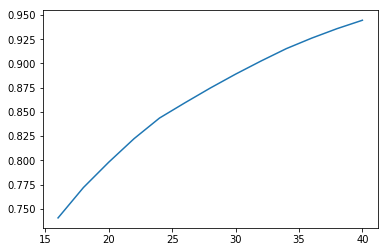

In [37]:
plt.plot(n_components, max_cum)

In [11]:
n_component = 32
pca = PCA(n_component)
pca.fit(df_scaled)
X_pca = pca.transform(df_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

Without specifying the number of component, I saw that we could explain 80% of variance with roughly the first 20 components. Then I iterated in the range of 16-42 and saw that by reducing the number of component to 22 you already explained 82% of the variange and that adding 10 more components got you to almost 90%. Depending on the use case, it might be necessary to keep 32 components. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [19]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
print(f"components: {pca.components_[0]}")
print(f"variance: {pca.explained_variance_ratio_[0]}")
len(pca.components_[0])   # Should be the same length as the number of features

components: [-0.11735833  0.00965702 -0.22114302  0.14479123 -0.11246305  0.06791136
  0.07230779  0.16562869 -0.11024599  0.02981886 -0.01657879  0.0415205
  0.07558261  0.11078583  0.07764371 -0.04206113 -0.07047995 -0.07361298
  0.06993432  0.09383696  0.00550485  0.02538373  0.0419844   0.11386083
  0.08670748 -0.00198504 -0.0797757  -0.00394494  0.20531515  0.03778038
 -0.05953894  0.13779081  0.03521343 -0.16937764 -0.05430086  0.05562555
  0.205702   -0.22787753  0.00857058  0.13685507  0.15500967 -0.21978162
 -0.12934386  0.19807878 -0.16695976 -0.11806064  0.0434447  -0.24453992
 -0.04680643  0.07258815 -0.0791276  -0.22835516  0.15559524  0.22893057
  0.22193956  0.04185485 -0.16956117  0.14606972  0.19988219  0.13716676
  0.10344437 -0.11024599]
variance: 0.17149212267745395


62

In [12]:
features = df.columns
df_components = pd.DataFrame(pca.components_, columns=features)
#print(pd.DataFrame(pca.components_[:2],columns=, index = ['PC-1','PC-2']))
df_components.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0             -0.117358   0.009657          -0.221143       0.144791   
1              0.261329   0.090863           0.069109      -0.237868   
2              0.078167  -0.368161           0.155354      -0.106215   
3             -0.042786   0.037692           0.067472      -0.004956   
4             -0.002123   0.007896           0.087122      -0.006693   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0         -0.112463        0.067911               0.072308          0.165629   
1          0.234011       -0.205988              -0.229065          0.114945   
2          0.100603       -0.189590              -0.099994         -0.041855   
3         -0.016364       -0.126065               0.081071         -0.110438   
4         -0.060396        0.036980              -0.046964         -0.087652   

   GREEN_AVANTGARDE  HEALTH_TYP    ...     PLZ8_ANTG2  PLZ8_ANTG3  PLZ8_ANTG4  \
0         -0.110246    0.029819    ...       0.155595    0.228931    0.221940   
1         -0.014132   -0.059072    ...       0.062150    0.090317    0.086227   
2          0.047876   -0.022621    ...       0.031079    0.046591    0.046855   
3          0.400760    0.005947    ...       0.107024    0.101623    0.083230   
4          0.061282    0.013730    ...      -0.094683   -0.027430    0.013650   

   PLZ8_HHZ  PLZ8_GBZ    ARBEIT  ORTSGR_KLS9  RELAT_AB    decade  movement  
0  0.041855 -0.169561  0.146070     0.199882  0.137167  0.103444 -0.110246  
1  0.012108 -0.069836  0.065812     0.087826  0.063220 -0.243646 -0.014132  
2  0.004208 -0.039698  0.036059     0.048144  0.032736 -0.110633  0.047876  
3  0.141017  0.036131  0.052097     0.248764  0.095605  0.029611  0.400760  
4 -0.495250 -0.404340  0.218368     0.091097  0.151148  0.018772  0.061282  

[5 rows x 62 columns]

In [13]:
def print_component_weights(df, row):
    """ Print and return a sorted pandas series of feature weights for a component.
        INPUT: DF of component, component number
        OUTPUT: sorted series.
    """
    res = df_components.loc[row]
    res.sort_values(ascending=True, inplace=True)
    print(res)
    return res

In [22]:
#w0 = print_component_weights(df_components, 0)

In [77]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
#w1 = print_component_weights(df_components, 1)

In [78]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
#w2 = print_component_weights(df_components, 2)

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

Across all three components Personality typology features (SEMIO XXX) are either highly positively or negatively important. This is a set of features that should be prioritize in data gathering and clean-up exercise. 

The positive or negative sign simply suggest positive or negative impact in the construction of the component which is a combination of features.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [17]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
scores = []
centers = list(range(1, 15, 2))
for center in centers:
    kmeans = KMeans(center)
    model = kmeans.fit(X_pca)
    score = abs(model.score(X_pca))
    scores.append(score)
    print(f"{center} centers: {score:.2e}")  

1 centers: 44,332,449.131142505
3 centers: 34,735,216.651342995
5 centers: 31,218,161.057363506
7 centers: 28,849,300.83475523
9 centers: 27,432,468.00366955
11 centers: 26,095,903.64669849
13 centers: 25,593,366.61988471


Text(0.5,1,'Elbow graph')

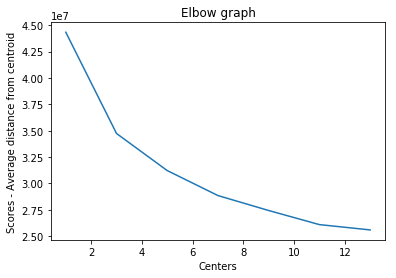

In [19]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centers, scores)
plt.xlabel('Centers')
plt.ylabel('Scores - Average distance from centroid')
plt.title('Elbow graph')

In [14]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
center = 10
kmeans = KMeans(center)
model = kmeans.fit(X_pca)
score = abs(model.score(X_pca))
print(f"{center} centers: {score:.2e}")

10 centers: 2.68e+07


In [30]:
labels = set(kmeans.labels_)
print(f"Unique labels: {labels}")
print(f"Cluster memberships: {kmeans.labels_}")

Unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Cluster memberships: [5 2 2 ..., 6 4 1]


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

By using the Elbow graph analysis is become clear that after 10 clusters, the scores start to flatten. I therefore chose to segment the population into 10 segments.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [15]:
# Load in the general demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

max_row, max_col = customers.shape
print(f"Shape of customer data: {max_row:,} x {max_col:,}")

Shape of customer data: 191,652 x 85


In [16]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
df_customers  = clean_data(customers, feat_info)

	Shape of DF:(191652, 85) 
1. Convert missing value codes into NaNs...
2. Removing cols with alot of missing data...
	Col drop criterion > 200,000
	Drop 6 attributes: ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
	Shape of DF:(191652, 79) 
3. Removing rows with alot of missing data...
	Row drop criterion > 20.00%
	Drop 50,754 or 26.48% of rows
	Shape of DF:(140898, 79) 
4. Convert binary attribute to number...
5. Remove the binary attributes
	Drop 14 categorical attributes
	Shape of DF: (140898, 65)
6. Cleaning two mixed attributes...
	Dropping 5 mixed attributes: ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'PLZ8_BAUMAX']
	Shape of DF: (140898, 62)
*** DONE! ***


In [17]:
res_cust = print_df_missing_data(df_customers)

Shape [140898][62]
 29 have missing data 
 KKK                     6.749564
REGIOTYP                6.749564
W_KEIT_KIND_HH          5.527403
KBA05_GBZ               3.745263
MOBI_REGIO              3.743843
KBA05_ANTG1             3.743843
KBA05_ANTG2             3.743843
KBA05_ANTG3             3.743843
KBA05_ANTG4             3.743843
RETOURTYP_BK_S          2.144814
ONLINE_AFFINITAET       2.144814
ANZ_HAUSHALTE_AKTIV     1.687036
HEALTH_TYP              1.613224
ANZ_HH_TITEL            1.499666
PLZ8_ANTG1              1.481213
PLZ8_ANTG2              1.481213
PLZ8_ANTG3              1.481213
PLZ8_ANTG4              1.481213
PLZ8_HHZ                1.481213
PLZ8_GBZ                1.481213
KBA13_ANZAHL_PKW        0.535849
ARBEIT                  0.403129
RELAT_AB                0.403129
ORTSGR_KLS9             0.387514
ALTERSKATEGORIE_GROB    0.162529
BALLRAUM                0.022002
EWDICHTE                0.022002
INNENSTADT              0.022002
KONSUMNAEHE             0.003549


In [52]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and do that now.
df_customers[:] = imputer.transform(df_customers)
print("Finished imputer()...")
col = df_customers.columns

df_scaled_cust = pd.DataFrame(scaler.transform(df_customers), columns=col)  # Need to use DataFrame to keep col
print("Finished scaler()...")

X_cust = pca.transform(df_scaled_cust)
print("Finished pca()...")

Finished imputer()...
Finished scaler()...
Finished pca()...


In [53]:
X_cust.shape

(140898, 32)

In [54]:
model_cust = kmeans.predict(X_cust)

In [55]:
#type(model_cust)
model_cust[:5]

array([0, 8, 3, 6, 0], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [56]:
# Create DF with the resulting labels
df_model       = pd.DataFrame(model.labels_, columns = ['labels'])
df_model_cust  = pd.DataFrame(model_cust, columns = ['labels'])
model_row      = df_model.shape[0]
model_row_cust = df_model_cust.shape[0]

In [57]:
# Calculate the cluster distribution in the population and the customer
model_clusters   = df_model['labels'].value_counts()*100/model_row
customer_cluster = df_model_cust['labels'].value_counts()*100/model_row_cust
cluster_difference = customer_cluster - model_clusters

In [115]:
cluster_difference

0    25.977488
1    -6.016746
2    -2.307120
3     8.099950
4    -9.296876
5    -2.888968
6    -1.114561
7    -7.619026
8     4.796382
9    -9.630522
Name: labels, dtype: float64

Cluster zero is disportionally represented in the customers

### What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population?

In [116]:
# Find the rows that were associated with the cluster in the general population. 
# Using the general population since it has more data and therefore the averages will be more representative
row_cluster = df_model_cust.labels[df_model_cust.labels == 0].index.tolist()  
print(df_model_cust.shape)
print(len(row_cluster))

(140898, 1)
47251


In [117]:
# Need to reset index b/c we droped some rows, using the scale data to make the comparison to not get skewed by size
df_cust2 = df_scaled_cust.reset_index().drop('index', axis=1)  
#df_cust2.head()

In [118]:
# Creating two groups of customers. Those in key cluster and those not in key cluster
df_customers_cluster = df_cust2.loc[row_cluster]
df_customers_others  = df_cust2.drop(row_cluster, axis=0)
df_customers_cluster.shape

(47251, 62)

In [119]:
# Do comparison using mean
key_cluster_mean = df_customers_cluster.mean()
non_cluster_mean = df_customers_others.mean()
mean_diff = key_cluster_mean - non_cluster_mean
mean_diff.sort_values(inplace=True)

In [123]:
mean_diff_abs = mean_diff.abs().rename('abs')
mean_diff = pd.concat([mean_diff, mean_diff_abs], axis=1)

In [129]:
key_cluster_main_attributes = mean_diff[mean_diff['abs']>=.5]
key_cluster_main_attributes

0       abs
HH_EINKOMMEN_SCORE -1.120814  1.120814
SEMIO_KAEM         -1.025151  1.025151
ANREDE_KZ          -0.995647  0.995647
SEMIO_KRIT         -0.947245  0.947245
SEMIO_ERL          -0.725425  0.725425
FINANZ_HAUSBAUER   -0.705275  0.705275
CAMEO_INTL_2015    -0.581422  0.581422
SEMIO_DOM          -0.572306  0.572306
REGIOTYP           -0.547127  0.547127
KKK                -0.524288  0.524288
MOBI_REGIO          0.604251  0.604251
FINANZ_MINIMALIST   0.669871  0.669871
KBA05_ANTG1         0.721324  0.721324
SEMIO_KULT          0.729736  0.729736
SEMIO_VERT          0.896479  0.896479
GREEN_AVANTGARDE    1.796783  1.796783
movement            1.796783  1.796783

In [136]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
row_cluster = df_model_cust.labels[df_model_cust.labels == 4].index.tolist()  
print(df_model_cust.shape)
print(len(row_cluster))
df_customers_cluster = df_cust2.loc[row_cluster]
df_customers_others  = df_cust2.drop(row_cluster, axis=0)
df_customers_cluster.shape

# Do comparison using mean
key_cluster_mean = df_customers_cluster.mean()
non_cluster_mean = df_customers_others.mean()
mean_diff = key_cluster_mean - non_cluster_mean
mean_diff.sort_values(inplace=True)

mean_diff_abs = mean_diff.abs().rename('abs')
mean_diff = pd.concat([mean_diff, mean_diff_abs], axis=1)

(140898, 1)
2234


In [137]:
key_cluster_main_attributes = mean_diff[mean_diff['abs']>=1]
key_cluster_main_attributes

0       abs
ALTERSKATEGORIE_GROB  -1.731549  1.731549
FINANZ_VORSORGER      -1.293107  1.293107
SEMIO_VERT            -1.257282  1.257282
SEMIO_LUST            -1.046983  1.046983
SEMIO_REL              1.011591  1.011591
SEMIO_DOM              1.061030  1.061030
FINANZ_UNAUFFAELLIGER  1.156721  1.156721
FINANZ_SPARER          1.187656  1.187656
ANREDE_KZ              1.302445  1.302445
SEMIO_PFLICHT          1.531402  1.531402
decade                 1.553445  1.553445
FINANZ_ANLEGER         1.577114  1.577114
SEMIO_TRADV            1.722418  1.722418
SEMIO_RAT              1.975120  1.975120

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

I chose to keep 10 cluster for the overall population. When I applied the same series of transformation to the customer dataset, I found that two segments was over represented and one by a significant margin (25%). I therefore focused on that segment (cluster 0). For the under represented, there were two that were under represented by ~8.5% and I picked cluster 4. 

I then went back to the scaled data and identified only the row linked to cluster 0 kept only the attributes that had a difference greater than .5. I did a similar approach for cluster 4 but chose a cut-off of 1. I then used the Data_dictionary to look at the types of data that was positively or negatively represented in this segment. The conclusions are as follows.

The mail-in offer seems to have attracted more customers that are older, avant-guard, member of an environment group and wealthy. They lean towards more cultural minded. Similarly, the mail-in offer seems less attractive to  younger demographic and rational-traditionalist-investor minded customers. 

Together these insights lead me to believe that the product offers of the company have been very successful to highly educated older customers who might be willing to "splurge" on somethign or be attractive to "environmental causes)  while less relevant to younger customers who are more traditionalize and potentially more frugal.

Assuming that the product to be offer remains the same and therefore the goal is to find more customers that have the same attributes, it is interesting to note that 17 attributes (out of the orginal 85 attributes) would be highly deterministic. This could inform the kind of data to be purchased and where to focus efforts on data clean-up.

Fun!

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

In [ ]:

    """
    ******NOT USED - OLD VERSION*******
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    max_row, max_col = azdias.shape
    
    print("1. Convert missing value codes into NaNs...")
    # Find attributes where missing values
    df = feat_info
    df['Flags'] = df.iloc[:,3].apply(lambda x: x[1:-1].split(',')) # Convert the str to list of str

    df2 = azdias.copy()
    for index, row in df.iterrows(): 
        attr = row["attribute"]
        flags = row["Flags"]
        for flag in flags: 
            if flag == 'X' or flag == 'XX':                   # case where there is a str
                df2[attr].replace(flag, np.nan, inplace=True)
            elif flag == '':                                  # Case where there is no item
                continue
            else:                                             # Case where there is a integer
                df2[attr].replace(int(flag), np.nan, inplace=True)
                #print(attr, flag, test)
    azdias = df2            
    
    print("2. Removing cols with alot of missing data...")
    post = azdias.isna().sum() 
    #print(f" No. of attributes with missing data {post[post>0].count()} out of {max_col}") 
    criterion = 200000
    col_to_investigate = post[post>criterion].index.tolist() 
    azdias_new  = azdias.drop(col_to_investigate, axis=1)
    print(f"\tCol drop criterion > {criterion:,}")
    print(f"\tDrop {len(col_to_investigate)} attributes: {col_to_investigate}")
    print(f"\tShape of DF:{azdias.shape} ")
    max_col_new = azdias_new.shape[1]

    print("3. Removing rows with alot of missing data...")
    row_missing_data = azdias_new.isna().sum(axis=1)/max_col_new   # represent as %
    criterion = .2
    list_of_rows = row_missing_data[row_missing_data>criterion].index.tolist()  
    print(f"\tRow drop criterion > {criterion*100:.2f}%")
    print(f"\tDrop {len(list_of_rows):,} or {len(list_of_rows)*100/max_row:.2f}% of rows")
    azdias_new_low = azdias_new.drop(list_of_rows)
    print(f"\tShape of DF:{azdias_new_low.shape} ")
    azdias_new2 = azdias_new_low.copy()
    
    ### select, re-encode, and engineer column values.
    
    # Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?
    categorical = feat_info[feat_info['type'] == 'categorical']['attribute'].tolist()  # get a list of categorical attributes 
    mixed       = feat_info[feat_info['type'] == 'mixed']['attribute'].tolist()        # get a list of mixed attributes
    mixed.remove("KBA05_BAUMAX")                                                       # Already removed
    categorical = list(set(categorical) & set(azdias_new_low.columns))   # Necessary to eliminate the attributes already eliminated

    print("4. Convert binary attribute to number...")
    quick_dict = {'W': 1, 'O':2}
    azdias_new2['OST_WEST_KZ'] = azdias_new2['OST_WEST_KZ'].replace(quick_dict)

    categorical_bin = []
    for col in categorical:
        tmp = azdias_new2[col].unique()
        #print(f"{col}:\t\t{tmp}")
        if len(tmp) == 2:
            categorical_bin.append(col) 
    
    categorical_to_drop = categorical

    print("5. Remove the binary attributes")
    for col in categorical_bin:
        categorical_to_drop.remove(col)

    print(f"\tDrop {len(categorical_to_drop)} categorical attributes" )

    azdias_new2.drop(categorical_to_drop, axis=1, inplace=True)
    print(f"\tShape of DF: {azdias_new2.shape}")
    
    PRAEGENDE_dict = { 1: [40, 1],  2: [40, 2], 3: [50, 1],  4: [50, 2],
                       5: [60, 1],  6: [60, 2], 7: [60, 2],  8: [70, 1], 9: [70, 2],
                      10: [80, 1], 11: [80, 2], 12: [80, 1], 13: [80, 2], 
                      14: [90, 1], 15: [90, 2], np.nan: [90, 1]
                     }

    # Create a DF with the lists in each cell 
    print("6. Cleaning two mixed attributes...")
    b = azdias_new2["PRAEGENDE_JUGENDJAHRE"].map(PRAEGENDE_dict).to_frame()  
    azdias_new2[['decade','movement']]= pd.DataFrame(b.PRAEGENDE_JUGENDJAHRE.tolist(), index= b.index) # Create the two columns
    
    
    azdias_new2["CAMEO_INTL_2015"].replace(np.nan, 52, inplace=True)  
    
    mixed.remove("CAMEO_INTL_2015")  # Do not remove this column
    
    azdias_new2.drop(mixed, axis=1, inplace=True)
    print(f"\tDroping {len(mixed)} mixed attributes: {mixed}")
    print(f"\tShape of DF: {azdias_new2.shape}")

    # Data type of the attribute is string. Need to convert to integer first. 
    # Then note that by dividing by 10 and reconverting to integer we can do the mapping
    azdias_new2["CAMEO_INTL_2015"] = azdias_new2["CAMEO_INTL_2015"].astype('int').div(10).astype('int')
    
    ### Return the cleaned dataframe.
    print("*** DONE! ***")
    return azdias_new2